# An improved Visibility model using MFT's, rather than FFT's

In [1]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import vmap
from matplotlib import colormaps

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]
coolwarm = colormaps["coolwarm"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)
coolwarm.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files


def load_cal(file_path, dithers=5, filters=["F380M", "F430M", "F480M"]):
    files = get_files(
        [f"{file_path}/CAL04481/calslope/"],
        "calslope",
        IS_PSF=[True],  # Calibrators
        EXPOSURE=[str(i + 1) for i in range(dithers)],
        FILTER=filters,
    )
    for file in files:
        file["BADPIX"].data[:, -1:] = 1
        file["BADPIX"].data[41:43, 1] = 1
        file["BADPIX"].data[58, 67] = 1
    return files

In [3]:
import jax.tree as jtu
from amigo.model_fits import PointFit
from amigo.core_models import initialise_model
from amigo.optical_models import AMIOptics

# # Build the model
files = load_cal("data/JWST", dithers=1, filters=["F430M"])
Teff_cache = "../data/Teffs"
optics = AMIOptics(coherence_orders=4)
model, exposures = initialise_model(
    files, PointFit(), optics=optics, Teff_cache=Teff_cache
)

## Find the OTF mask

The OTF is calculated at the autocorrelation of the aperture mask. Note we MUST use `mode='full'` to avoid off-by-one errors.

We need to find the threshold at which we capture only the OTF of the resulting autocorrelation to build the mask. This can be done by finding the range of values at which the fraction of the total array that is masked plateaus.

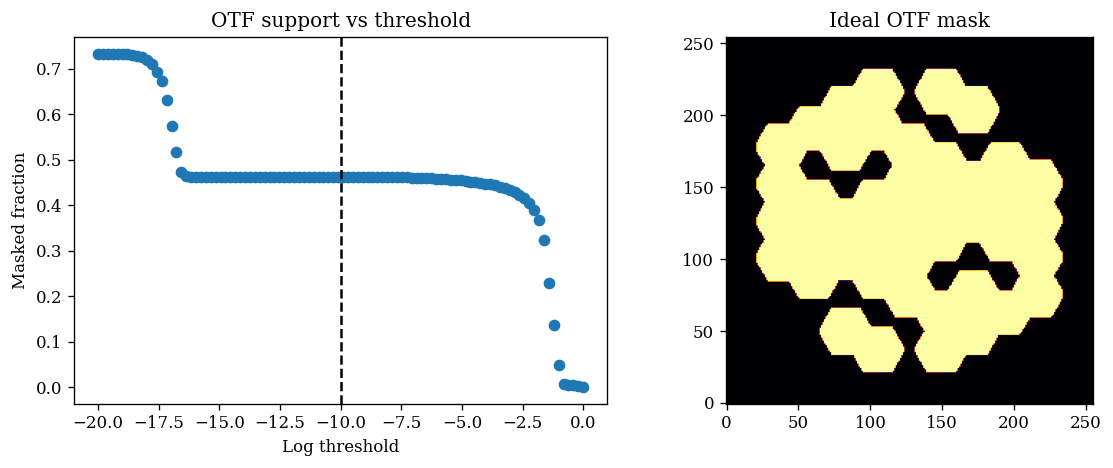

In [4]:
from jax.scipy.signal import correlate
import dLux.utils as dlu

# Mask down sampling factor
downsample = 8

# Log thresholds to examine
threshes = np.linspace(-20, 0, 100)

# Get the aperture mask
optics = model.optics
mask = optics.calc_mask(optics.wf_npixels, optics.diameter)
mask = dlu.downsample(mask, downsample)

# Get the OTF as the correlation of the Aperture Mask
corr = correlate(mask, mask, mode="full", method="fft")
otf = corr / corr.max()

# Get the masking fractions
fracs = []
for thresh in threshes:
    fracs.append((otf > (10.0**thresh)).sum() / otf.size)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("OTF support vs threshold")
plt.scatter(threshes, fracs)
plt.axvline(-10, c='k', ls='--')
plt.xlabel("Log threshold")
plt.ylabel("Masked fraction")

plt.subplot(1, 2, 2)
plt.title("Ideal OTF mask")
plt.imshow(otf > 10. ** -10)

plt.tight_layout()
plt.show()

## Examine our splodges and OTF mask

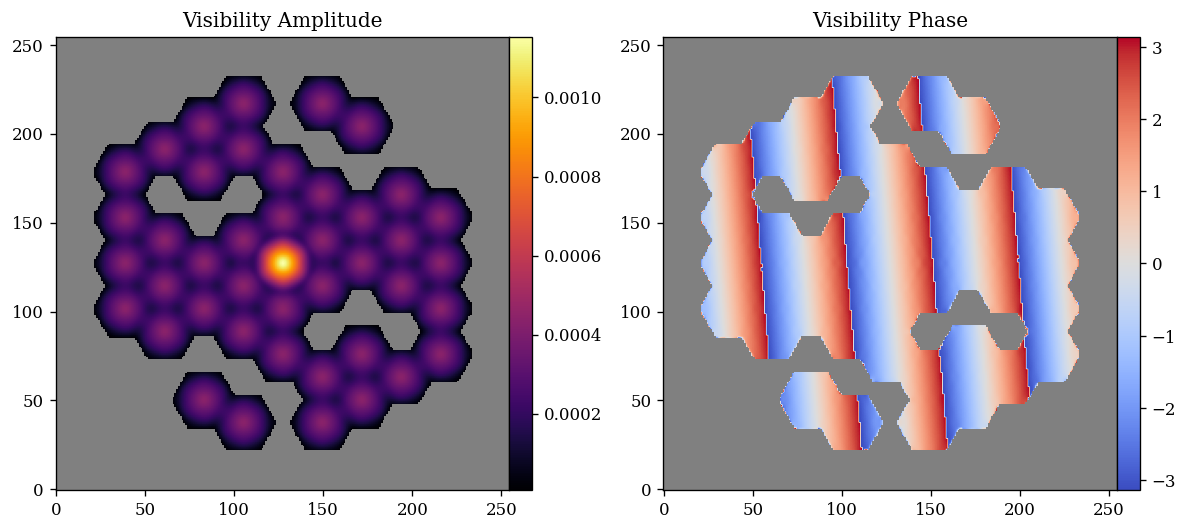

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dLux.utils as dlu
from jax.scipy.signal import correlate


def merge_cbar(ax):
    return make_axes_locatable(ax).append_axes("right", size="5%", pad=0.0)

# Get the Optics and exposure
optics = model.optics
exp = exposures[0]

# Get the optical parameters we need
apr_pix_scale = optics.diameter / optics.wf_npixels
psf_pix_scale = dlu.arcsec2rad(optics.psf_pixel_scale / optics.oversample)
psf_npixels = optics.psf_npixels * optics.oversample

# Calculate the Aperture mask
downsample = 8 # 16 is the minimal downsample that doesn't alias
npix = 2 * optics.wf_npixels / downsample
mask = optics.calc_mask(optics.wf_npixels, optics.diameter)
mask = dlu.downsample(mask, downsample)
splodge_pix_scale = apr_pix_scale * downsample

# Calculate the OTF mask
thresh = 1e-10
corr = correlate(mask, mask, mode="full", method="fft")
otf_mask = corr > (thresh * corr.max())

# To and from uv functions
to_uv = vmap(
    lambda psf, wl: dlu.MFT(psf, wl, psf_pix_scale, len(otf_mask), splodge_pix_scale)
)
from_uv = vmap(
    lambda splodges, wl: dlu.MFT(
        splodges, wl, splodge_pix_scale, psf_npixels, psf_pix_scale, inverse=True
    )
)


# Get some clean PSFS
wls = optics.filters[exp.filter][0]
clean_model = model.set("aberrations", jtu.map(lambda x: 0 * x, model.aberrations))
psfs = exp.fit.model_wfs(clean_model, exp).psf
psf = psfs.sum(0)

# Get the splodges
raw_splodges = to_uv(psfs, wls)
splodges = vmap(lambda x: np.where(otf_mask, x, np.nan))(raw_splodges)[-1]
inv_splodges = vmap(lambda x: np.where(otf_mask, np.nan, x))(raw_splodges)[-1]

# Plot
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
ax.set(title="Visibility Amplitude")
im = ax.imshow(np.sqrt(np.abs(splodges)), cmap=inferno)
fig.colorbar(im, cax=merge_cbar(ax))

ax = plt.subplot(1, 2, 2)
ax.set(title="Visibility Phase")
im = ax.imshow(np.angle(splodges), cmap=coolwarm)
fig.colorbar(im, cax=merge_cbar(ax))

plt.tight_layout()
plt.show()

## Calculate the per-baseline splodge masks

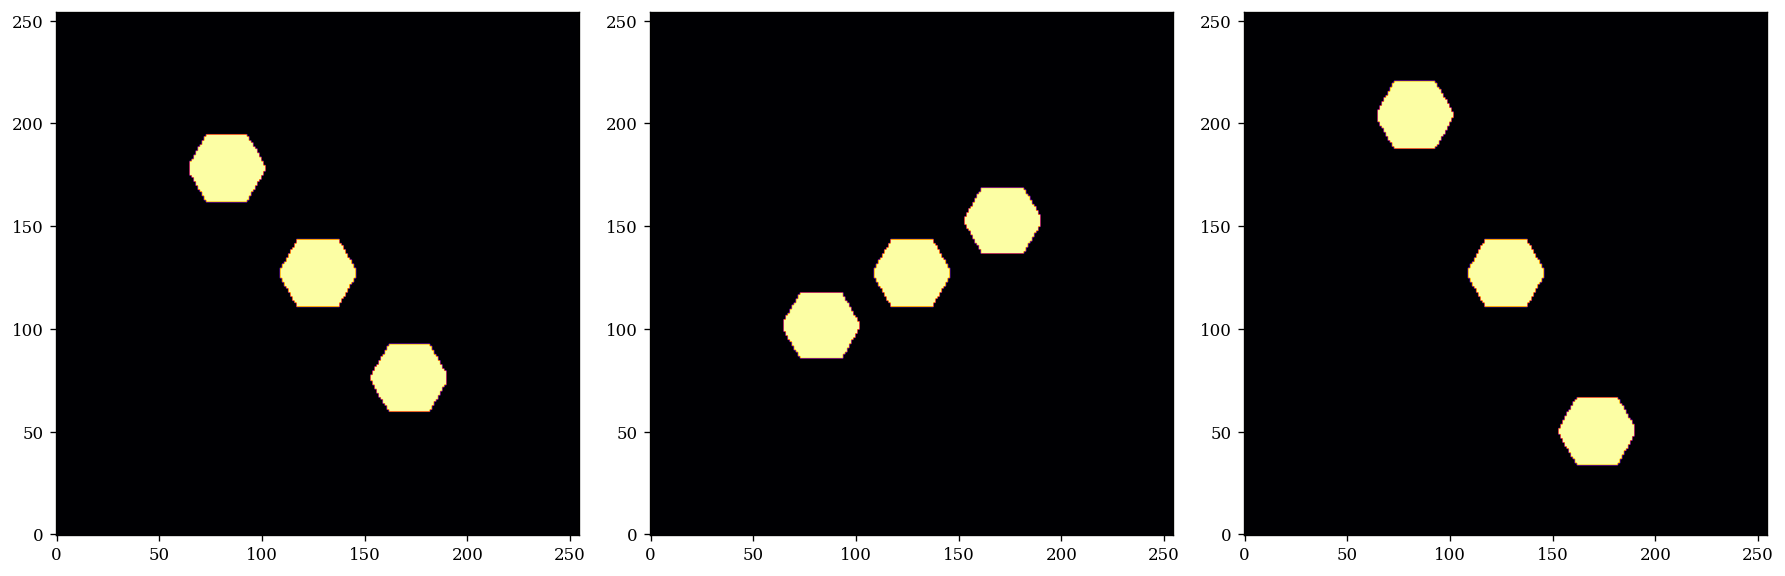

In [6]:
from amigo.vis_models import get_hole_mask

thresh = 1e-10
holes = optics.holes
mask = optics.calc_mask(optics.wf_npixels, optics.diameter)
coords = dlu.pixel_coords(optics.wf_npixels, optics.diameter)

splodge_masks = {}
for i in range(len(holes)):
    for j in range(len(holes)):
        if i == j or (j, i) in splodge_masks.keys():
            continue

        pt1, pt2 = holes[i], holes[j]
        hole_mask = np.zeros_like(mask, bool)
        hole_mask = get_hole_mask(pt1, hole_mask, coords)
        hole_mask = get_hole_mask(pt2, hole_mask, coords)

        reduced_mask = dlu.downsample(mask * hole_mask, downsample)
        # corr = correlate(reduced_mask, reduced_mask, method="fft")
        corr = correlate(reduced_mask, reduced_mask, mode="full", method="fft")
        corr /= corr.max()
        splodge_masks[(i, j)] = (corr > thresh).astype(float)

# Plot
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(splodge_masks[(0, i + 1)])
plt.tight_layout()
plt.show()

In [7]:
def find_knot_inds(full_knot_map):

    flat_knot_map = full_knot_map.flatten()
    n = len(flat_knot_map) // 2
    return np.where(flat_knot_map[:n])

In [8]:
# plt.imshow(full_knot_map)

## Find our knot coords and their conjugates

(1, 597)
N Knots 597


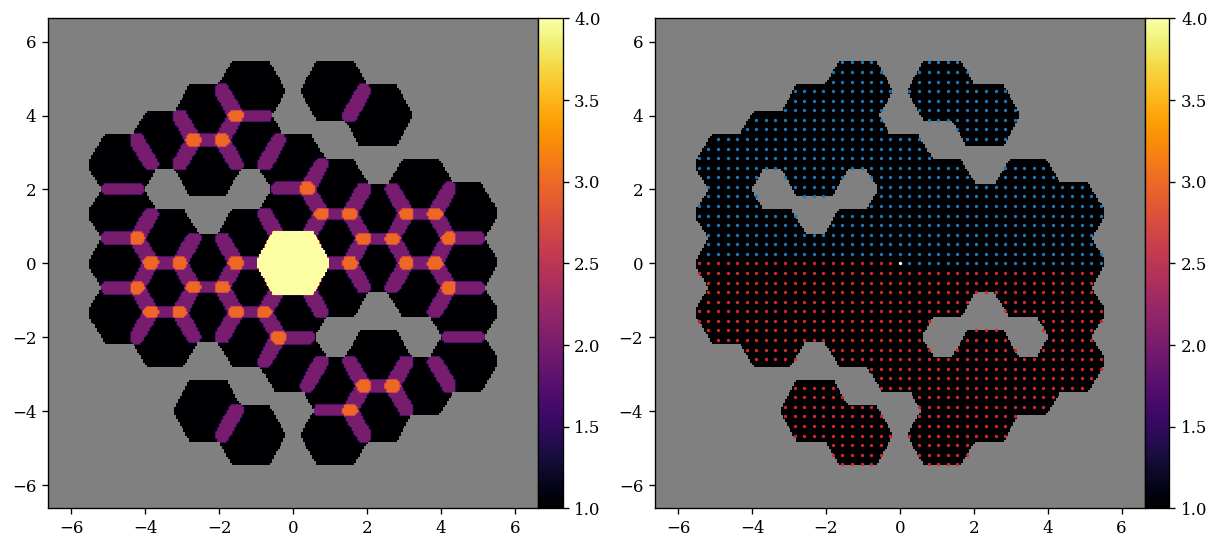

In [9]:
from amigo.vis_models import find_valid_knot_map, find_knot_map#, find_knot_inds

factor = 5
n = len(splodges)
n_knots = n // factor
otf_diam = 2 * optics.diameter

otf_coords = dlu.pixel_coords(n, otf_diam)
knot_coords = dlu.pixel_coords(n_knots, otf_diam)

otf_support = dlu.downsample(otf_mask, factor)
full_knot_map = otf_support > 0.55
knot_inds = np.array(find_knot_inds(full_knot_map))
print(knot_inds.shape)

knot_map = find_knot_map(full_knot_map)
conj_map = np.flip(knot_map.flatten()).reshape(knot_map.shape)
print("N Knots", knot_map.sum())

valid_knot_coords = knot_coords[:, knot_map]
conj_knot_coords = knot_coords[:, conj_map]

baseline_im = np.array(jtu.leaves(splodge_masks)).sum(0)
baseline_im = np.where(baseline_im > 0.5, baseline_im, np.nan)
baseline_mask = np.where(baseline_im > 0.5, 1, np.nan)

r = (otf_diam / len(otf_mask)) * (len(otf_mask) + 1) / 2
extent = (-r, r, -r, r)

fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
im = ax.imshow(baseline_im, inferno, vmax=4, extent=extent)
fig.colorbar(im, cax=merge_cbar(ax))

ax = plt.subplot(1, 3, 2)
im = ax.imshow(baseline_mask, inferno, vmax=4, extent=extent)
plt.scatter(*valid_knot_coords, s=1, c="tab:blue")
plt.scatter(*conj_knot_coords, s=1, c="tab:red")
plt.scatter([0], [0], s=1, c="w")
fig.colorbar(im, cax=merge_cbar(ax))

plt.tight_layout()
plt.show()

## Check that our knot coords exactly sample a pixel in our splodge array

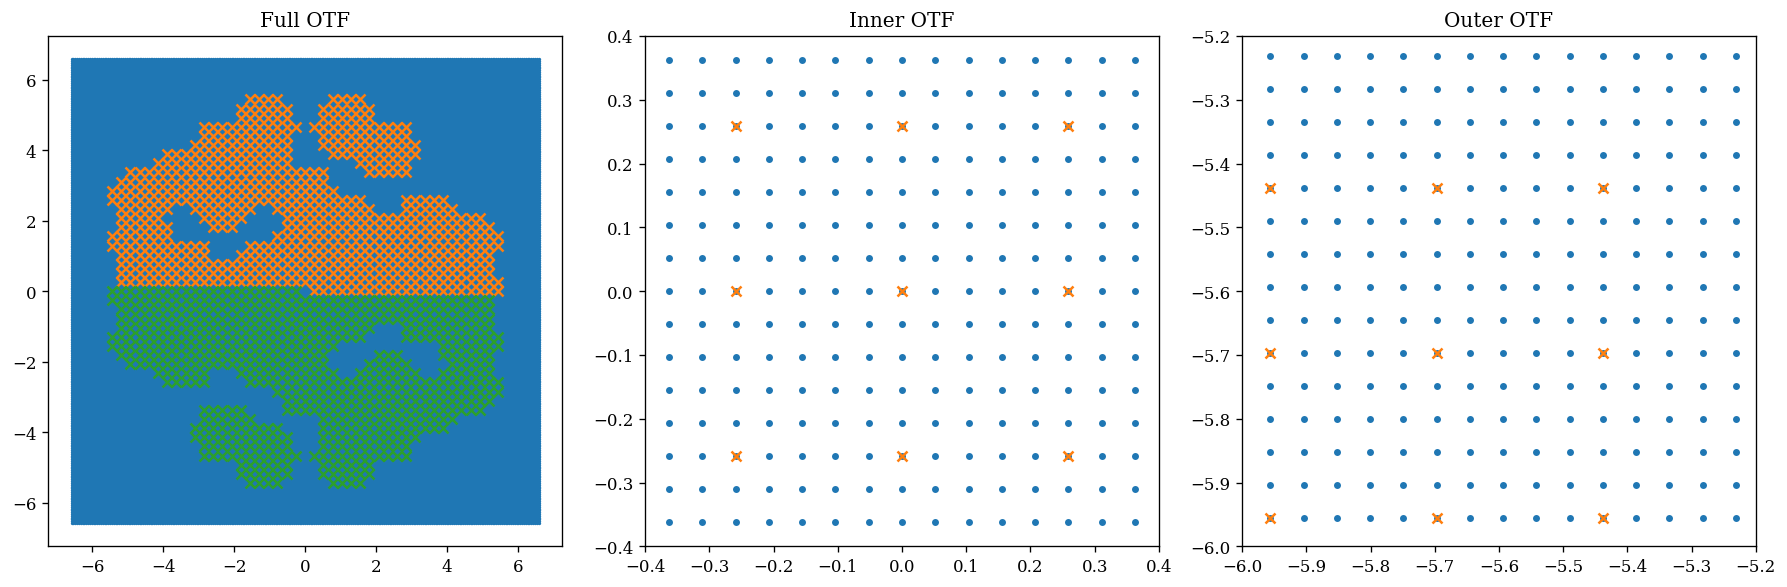

In [10]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Full OTF")
plt.scatter(*otf_coords, s=1)
plt.scatter(*valid_knot_coords, marker="x")
plt.scatter(*conj_knot_coords, marker="x")

plt.subplot(1, 3, 2)
plt.title("Inner OTF")
plt.scatter(*otf_coords, s=10)
plt.scatter(*knot_coords, marker="x")
plt.xlim(-0.4, 0.4)
plt.ylim(-0.4, 0.4)

plt.subplot(1, 3, 3)
plt.title("Outer OTF")
plt.scatter(*otf_coords, s=10)
plt.scatter(*knot_coords, marker="x")
plt.xlim(-6, -5.2)
plt.ylim(-6, -5.2)

plt.tight_layout()
plt.show()

In [11]:
from amigo.vis_models import build_vis_pts
import jax.random as jr

amps, phases = 0.1 * jr.normal(jr.PRNGKey(0), (2, knot_map.sum()))
# print(amps)

n_pts = knot_map.size // 2
amps = np.ones(n_pts).at[*knot_inds].set(1 + amps)
phases = np.zeros(n_pts).at[*knot_inds].set(phases)
vis_knot_vals = build_vis_pts(amps, phases, knot_map.shape)

In [12]:
otf_mask.shape

(255, 255)

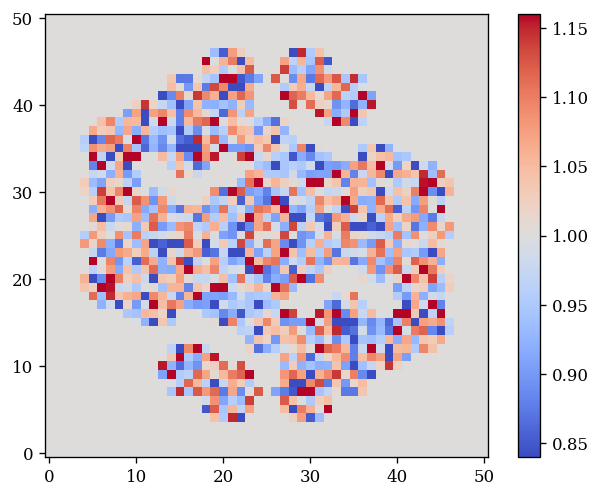

In [13]:
amps, phases = np.abs(vis_knot_vals), np.angle(vis_knot_vals)

v = 0.5 * np.nanmax(np.abs(1 - amps))
plt.imshow(amps, coolwarm, vmin=1-v, vmax=1+v)
plt.colorbar()
plt.show()

In [14]:
from scipy.ndimage import gaussian_filter
from amigo.misc import interp

interp_fn = lambda im, coords: interp(im, knot_coords, coords, method="linear")
smooth_fn = lambda x: np.where(full_knot_map,  gaussian_filter(x, 0.5), x)

# Smooth the amps and phases
full_amp = interp_fn(smooth_fn(amps), otf_coords)
full_pha = interp_fn(smooth_fn(phases), otf_coords)

full_amp = np.where(otf_mask, full_amp, np.nan)
full_pha = np.where(otf_mask, full_pha, np.nan)

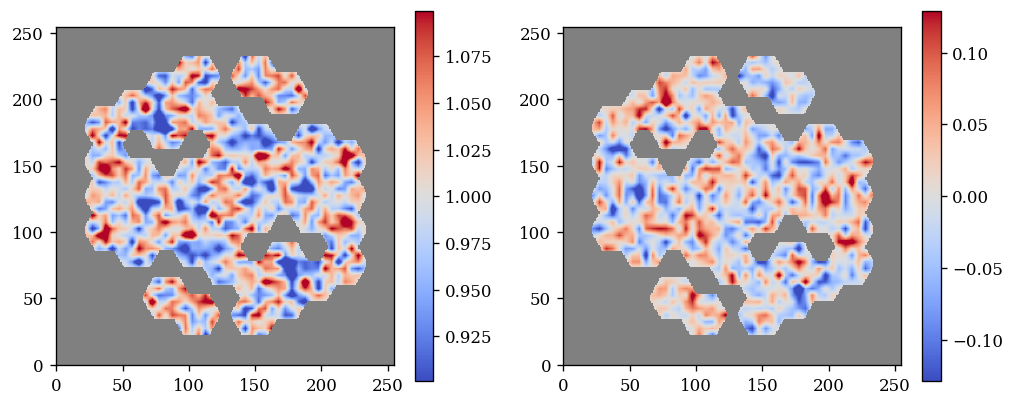

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
v = 0.5 * np.nanmax(np.abs(1 - full_amp))
plt.imshow(full_amp, coolwarm, vmin=1 - v, vmax=1 + v)
plt.colorbar()

plt.subplot(1, 2, 2)
v = 0.5 * np.nanmax(np.abs(full_pha))
plt.imshow(full_pha, coolwarm, vmin=-v, vmax=v)
plt.colorbar()

plt.show()

In [16]:
from amigo.vis_models import get_hole_mask

def calc_splodge_masks(optics, thresh=1e-10):
    holes = optics.holes
    mask = optics.calc_mask(optics.wf_npixels, optics.diameter)
    coords = dlu.pixel_coords(optics.wf_npixels, optics.diameter)

    splodge_masks = {}
    for i in range(len(holes)):
        for j in range(len(holes)):
            if i == j or (j, i) in splodge_masks.keys():
                continue

            pt1, pt2 = holes[i], holes[j]
            hole_mask = np.zeros_like(mask, bool)
            hole_mask = get_hole_mask(pt1, hole_mask, coords)
            hole_mask = get_hole_mask(pt2, hole_mask, coords)

            reduced_mask = dlu.downsample(mask * hole_mask, downsample)
            corr = correlate(reduced_mask, reduced_mask, mode="full", method="fft")
            corr /= corr.max()
            splodge_masks[(i, j)] = (corr > thresh).astype(float)
    return splodge_masks


def find_knot_inds(full_knot_map):
    flat_knot_map = full_knot_map.flatten()
    n = len(flat_knot_map) // 2
    return np.where(flat_knot_map[:n])

In [17]:
import equinox as eqx
import zodiax as zdx
import dLux as dl

class MFTVis(zdx.Base):
    method: str = eqx.field(static=True)
    otf_coords: np.ndarray
    knot_coords: np.ndarray
    otf_mask: np.ndarray
    knot_map: np.ndarray
    conj_map: np.ndarray
    knot_inds: np.ndarray
    uv_pscale: np.ndarray

    def __init__(self, optics, method="linear", sample_factor=5):
        if method not in ['linear']:
            raise ValueError("Presently only 'linear' is supported.")

        if sample_factor not in [3, 5]:
            raise ValueError("Under sample factor must be 3 or 5")

        self.method = method

        # Calculate the Aperture mask
        downsample = 8 # 16 is the minimal downsample that doesn't alias
        mask = optics.calc_mask(optics.wf_npixels, optics.diameter)
        mask = dlu.downsample(mask, downsample)

        # Get the fourier pixel scale
        self.uv_pscale = np.array(downsample * optics.diameter / optics.wf_npixels)

        # Calculate the OTF mask
        thresh = 1e-10
        corr = correlate(mask, mask, mode="full", method="fft")
        self.otf_mask = corr > (thresh * corr.max())

        n = len(self.otf_mask)
        n_knots = n // sample_factor
        otf_diam = 2 * optics.diameter

        self.otf_coords = dlu.pixel_coords(n, otf_diam)
        self.knot_coords = dlu.pixel_coords(n_knots, otf_diam)

        otf_support = dlu.downsample(self.otf_mask, sample_factor)
        full_knot_map = otf_support > 0.55
        self.knot_inds = np.array(find_knot_inds(full_knot_map))

        self.knot_map = find_knot_map(full_knot_map)
        self.conj_map = np.flip(self.knot_map.flatten()).reshape(self.knot_map.shape)
        print("N Knots", self.knot_map.sum())

    @property
    def valid_knot_coords(self):
        return self.knot_coords[:, self.knot_map]

    @property
    def conj_knot_coords(self):
        return self.knot_coords[:, self.conj_map]

    def interp_fn(self, im):
        return interp(im, self.knot_coords, self.otf_coords, method=self.method)

    def get_vis_map(self, amplitudes, phases):
        # Full the full array with the input amplitudes and phases
        n_pts = self.knot_map.size // 2
        amps = np.ones(n_pts).at[*self.knot_inds].set(amplitudes)
        phases = np.zeros(n_pts).at[*self.knot_inds].set(phases)

        # Get the amplitude and phase visibility maps
        vis_vals = build_vis_pts(amps, phases, self.knot_map.shape)
        amplitude = self.interp_fn(np.abs(vis_vals))
        phase = self.interp_fn(np.angle(vis_vals))

        # Return as a complex visibility surface
        return amplitude * np.exp(1j * phase)

    def model_vis(self, wfs, amps, phases):
        vis_maps = self.get_vis_map(amps, phases)

        # Get the bits we need
        wls = wfs.wavelength
        psf_pscale = wfs.pixel_scale[0]
        psf_npix = wfs.npixels
        uv_npix = len(self.otf_mask)

        # Fourier Functions
        to_uv = vmap(
            lambda arr, wl: dlu.MFT(arr, wl, psf_pscale, uv_npix, self.uv_pscale)
        )
        from_uv = vmap(
            lambda arr, wl: dlu.MFT(
                arr, wl, self.uv_pscale, psf_npix, psf_pscale, inverse=True
            )
        )

        # Masking fn
        mask_fn = vmap(lambda x, y: np.where(self.otf_mask, x, y))

        # Apply the visibility maps
        splodges = to_uv(wfs.psf, wls)
        applied = mask_fn(splodges * vis_maps, splodges)
        psfs = np.abs(from_uv(applied, wls))

        # Return the PSF object
        return dl.PSF(psfs.sum(0), wfs.pixel_scale.mean(0))

vis_model = MFTVis(optics)

N Knots 597


In [18]:
vis_model

MFTVis(
  method='linear',
  otf_coords=f64[2,255,255],
  knot_coords=f64[2,51,51],
  otf_mask=bool[255,255],
  knot_map=bool[51,51],
  conj_map=bool[51,51],
  knot_inds=i64[1,597],
  uv_pscale=weak_f64[]
)

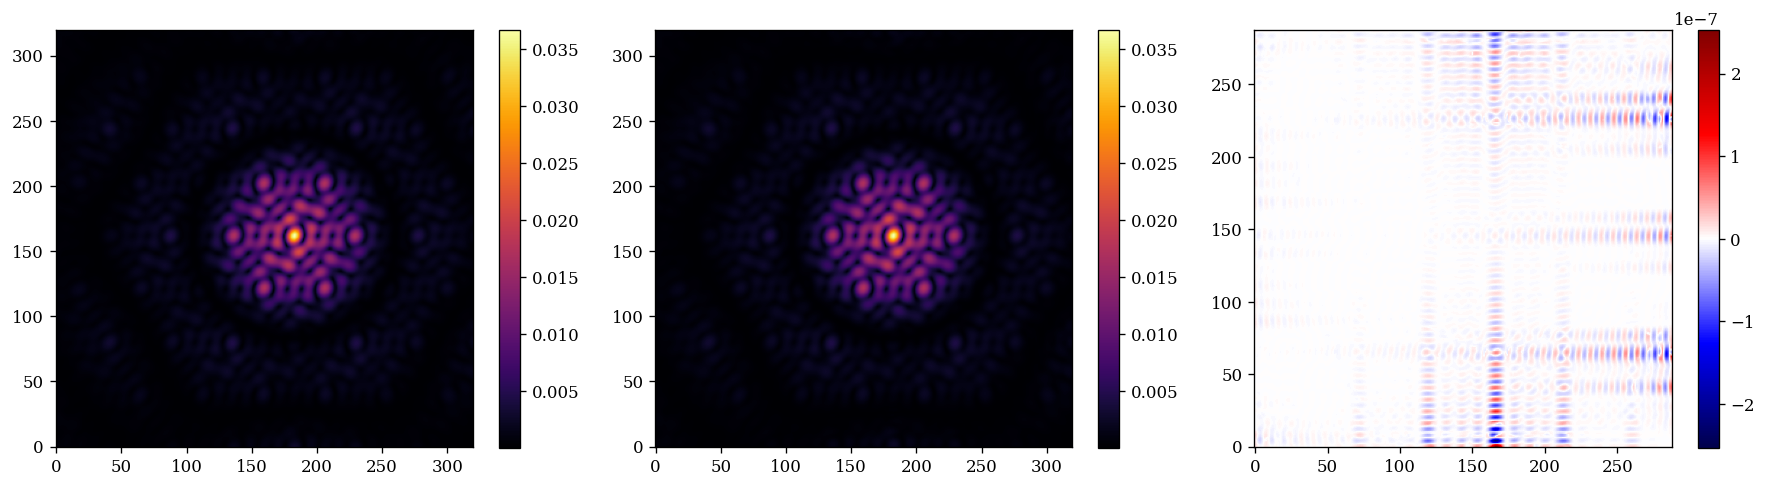

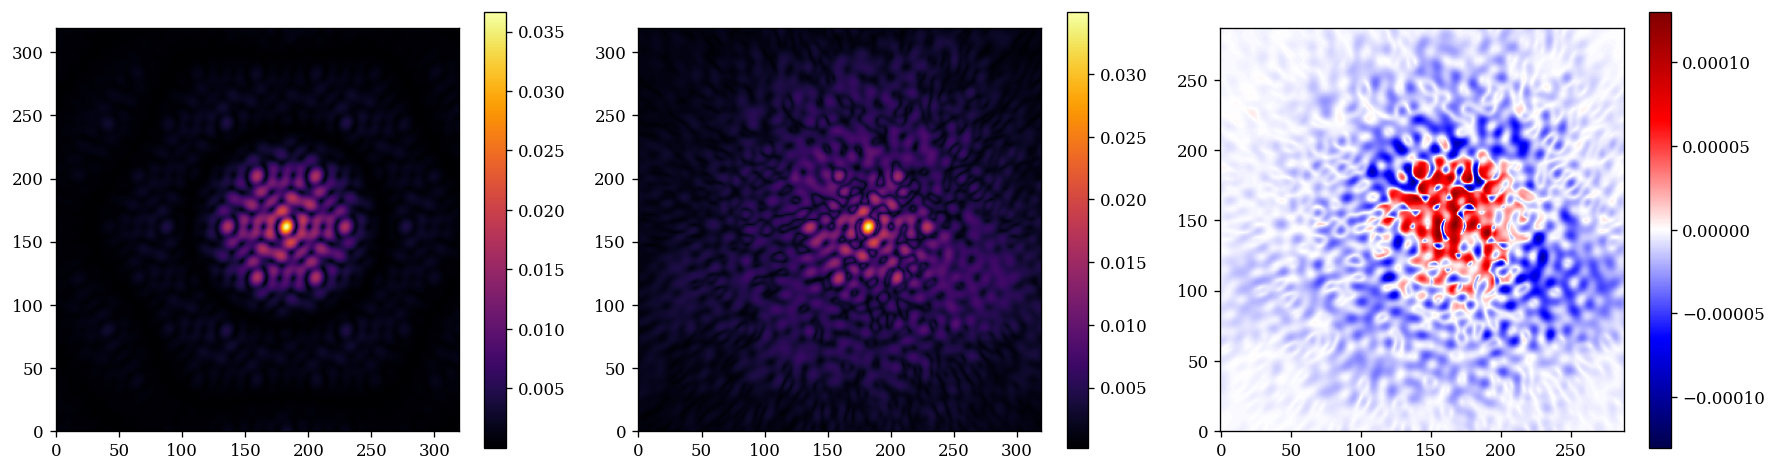

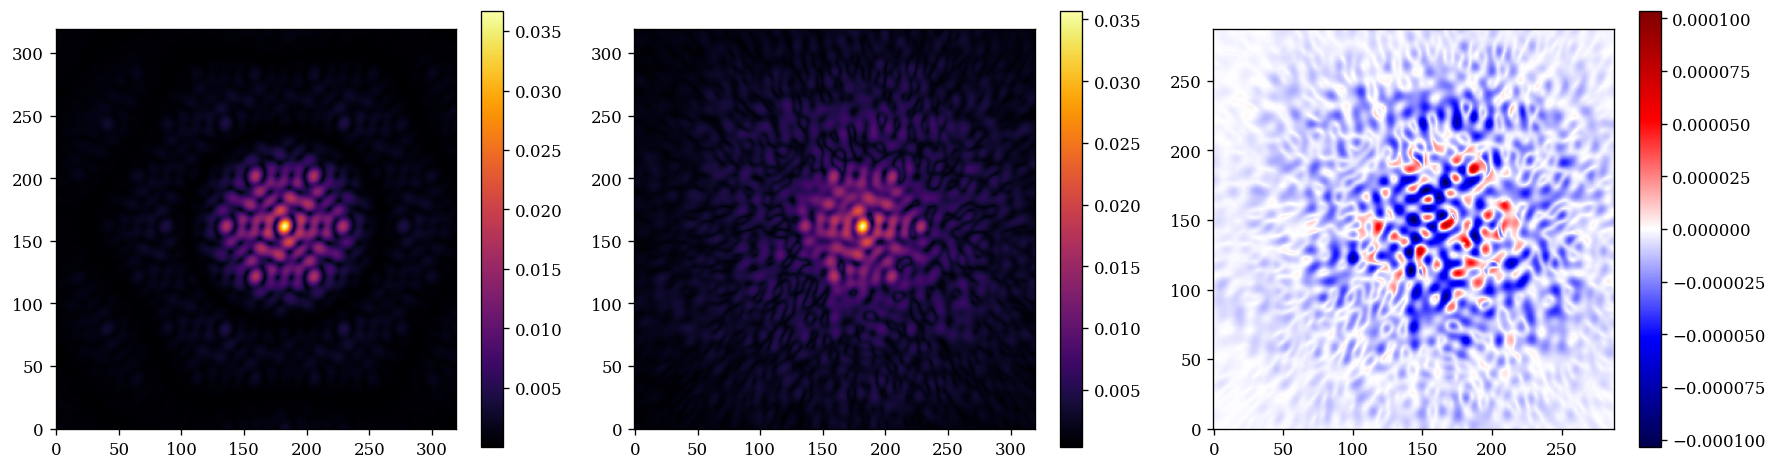

In [21]:
scale = 0.5

for i in range(3):
    if i == 0:
        amps = np.ones(597)
        phases = np.zeros(597)
    else:
        keys = jr.split(jr.PRNGKey(i))
        amps = 1 + scale * jr.normal(keys[0], (597,))
        phases = scale * jr.normal(keys[1], (597,))

    wfs = exp.fit.model_wfs(model, exp)
    psf_in = wfs.psf.sum(0)
    psf_out = vis_model.model_vis(wfs, amps, phases).data
    res = (psf_in - psf_out)[16:-16, 16:-16]
    v = np.nanmax(np.abs(res))

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(psf_in ** 0.5)
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(psf_out ** 0.5)
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.imshow(res, seismic, vmin=-v, vmax=v)
    plt.colorbar()

    plt.tight_layout()
    plt.show()